In [43]:
import numpy as np
import pandas as pd
import math
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
from sklearn.covariance import LedoitWolf

# ===========================
# DATA LOADING & PREP
# ===========================
def load_data(returns_path, asset_map_path, start=1970, end=2014):
    """Load and preprocess return and asset mapping data."""
    returns = pd.read_csv(returns_path, index_col=0, parse_dates=True)
    returns = returns[(returns.index.year > start) & (returns.index.year < end)]
    returns = returns.loc[returns.notna().sum(axis = 1) >=4]
    
    asset_map = pd.read_csv(asset_map_path)[['ID', 'AssetClass']].dropna()
    asset_map = asset_map[asset_map['ID'].isin(returns.columns)]
    return returns, asset_map


# -----------------------------
# Helper: Ex-ante vol (annualized)
# -----------------------------
def ex_ante_vol_one_date(w_vec, cov_mat):
    w = np.nan_to_num(w_vec, nan=0.0)
    C = np.nan_to_num(cov_mat.values, nan=0.0)
    sig2 = float(w @ C @ w.T)
    return math.sqrt(max(sig2, 0.0)) * math.sqrt(12.0)  # annualized

# -----------------------------
# Helper: Expanding covariances (as dict)
# -----------------------------
# def expanding_cov(returns, min_periods):
#     cov_dict = {}
#     for t in range(min_periods, len(returns)):
#         cov_dict[returns.index[t]] = returns.iloc[:t].cov()
#     return cov_dict

def dataframe_filt(dat, threshold=1):
    """
    Filters dataframe with specific threshold for valid values
    
    :param dat: input dataframe
    :param threshold: minimum number of non-NaN values required per column
    
    :return: filtered dataframe, with dropped columns
    """
    idx = dat.columns
    dat_filt = dat.reindex(columns=idx[dat.count() >= threshold])
    return dat_filt.copy()

def rolling_cov(returns, rolling_window = 5*260, min_periods=36):
    """
    Computes expanding covariance matrix
    Only includes assets that have at least min_periods of non-NaN data
    
    :param returns: DataFrame of returns
    :param min_periods: minimum months required for each asset
    
    :return: Dictionary with date as key, covariance matrix as value
    """
    cov_dict = {}
    
    for t in range(min_periods, len(returns)):
        # Get returns up to time t
        rets_upto_t = returns.iloc[:t][-rolling_window:]
        
        # Filter: only keep columns with at least min_periods non-NaN values
        rets_filt = dataframe_filt(rets_upto_t, threshold=min_periods,)
        
        # Compute covariance matrix only if we have valid data
        if rets_filt.shape[1] > 0:
            cov = rets_filt.cov().reindex(index=returns.columns, columns=returns.columns)
            cov_dict[returns.index[t]] = cov.copy()
    
    return cov_dict

def expanding_cov(returns, min_periods):
    """
    Computes expanding covariance matrix
    Only includes assets that have at least min_periods of non-NaN data
    
    :param returns: DataFrame of returns
    :param min_periods: minimum months required for each asset
    
    :return: Dictionary with date as key, covariance matrix as value
    """
    cov_dict = {}
    
    for t in range(min_periods, len(returns)):
        # Get returns up to time t
        rets_upto_t = returns.iloc[:t]
        
        # Filter: only keep columns with at least min_periods non-NaN values
        rets_filt = dataframe_filt(rets_upto_t, threshold=min_periods)
        
        # Compute covariance matrix only if we have valid data
        if rets_filt.shape[1] > 0:
            cov = rets_filt.cov().reindex(index=returns.columns, columns=returns.columns)
            cov_dict[returns.index[t]] = cov.copy()
    
    return cov_dict

def add_ledoit_wolf_shrinkage_optimal(cov_exp_dict, returns_df):
    """
    Apply optimal Ledoit-Wolf shrinkage to covariance matrices using original data.
    
    Parameters:
    -----------
    cov_exp_dict : dict
        Dictionary with dates as keys and sample covariance matrices as values.
    returns_df : pd.DataFrame
        DataFrame of original returns data with a datetime index (used for fitting).
    
    Returns:
    --------
    dict : Dictionary with same dates as keys and optimally shrunk covariance matrices as values.
    """
    
    shrunk_cov_dict = {}
    print(f"\nApplying optimal Ledoit-Wolf shrinkage...")
    
    # Initialize the LedoitWolf estimator
    lw = LedoitWolf()
    
    # Iterate through dates
    for date, cov_mat in cov_exp_dict.items():
        # Get the index of assets present in the current covariance matrix
        current_assets = cov_mat.index
        
        # Get the original returns data up to this date for these assets
        # We need historical data to compute the optimal shrinkage intensity
        historical_returns = returns_df.loc[:date, current_assets].dropna()
        
        n_samples, n_features = historical_returns.shape

        if n_samples < 2 or n_features < 2:
            print(f"  Warning: Insufficient data for shrinkage on {date}, skipping.")
            shrunk_cov_dict[date] = cov_mat.copy()
            continue
        
        try:
            # --- Use the sklearn LedoitWolf estimator to find optimal shrinkage ---
            # It fits the optimal shrinkage intensity and transforms the matrix
            lw.fit(historical_returns)
            shrunk_valid_cov_array = lw.covariance_
            optimal_intensity = lw.shrinkage_
            print(f"  {date}: Optimal intensity calculated: {optimal_intensity:.4f}")

            # Create full matrix (handles potential NaNs if original cov_mat had them)
            # This step might be simpler if cov_exp_dict only contains valid submatrices
            shrunk_cov_df = pd.DataFrame(
                shrunk_valid_cov_array,
                index=cov_mat.index,
                columns=cov_mat.columns
            )
            
            shrunk_cov_dict[date] = shrunk_cov_df
            
        except Exception as e:
            print(f"  Warning: Shrinkage failed for {date}: {e}")
            shrunk_cov_dict[date] = cov_mat.copy()
    
    return shrunk_cov_dict


def compute_cross_sectional_rank_signal(returns, asset_map, lookback=11, 
                                       long_threshold=0.6, short_threshold=0.4,
                                       neutral_signal=0):
    """
    Cross-sectional rank-based signal within each asset class
    Ranks assets by past returns within their asset class and goes long/short based on rank
    
    Parameters:
    -----------
    returns : pd.DataFrame
        Returns data with assets as columns
    asset_map : pd.DataFrame
        Mapping of asset IDs to asset classes (columns: 'ID', 'AssetClass')
    lookback : int
        Number of months to look back for momentum calculation
    long_threshold : float
        Percentile rank threshold for long positions (e.g., 0.8 = top 20% within class)
    short_threshold : float
        Percentile rank threshold for short positions (e.g., 0.2 = bottom 20% within class)
    neutral_signal : int
        Signal value for neutral positions (default 0)
    
    Returns:
    --------
    pd.DataFrame with signals (same shape as returns)
    """
    # Calculate past returns (momentum scores)
    past_returns = returns.rolling(window=lookback).sum().shift(1)
    
    # Initialize signal dataframe
    signal = pd.DataFrame(index=returns.index, columns=returns.columns, dtype=float)
    
    # Filter asset_map to only include assets in returns
    asset_map_filtered = asset_map[asset_map['ID'].isin(returns.columns)].copy()
    
    # Get unique asset classes
    asset_classes = asset_map_filtered['AssetClass'].unique()
    
    print(f"\nCross-sectional rank signal (within asset class):")
    print(f"  Lookback period: {lookback} months")
    print(f"  Long threshold: top {(1-long_threshold)*100:.0f}% within each class")
    print(f"  Short threshold: bottom {short_threshold*100:.0f}% within each class")
    
    # Statistics by asset class
    class_stats = {}
    
    for asset_class in asset_classes:
        # Get assets in this class
        assets_in_class = asset_map_filtered[
            asset_map_filtered['AssetClass'] == asset_class
        ]['ID'].tolist()
        
        # Filter to assets that exist in returns
        assets_in_class = [a for a in assets_in_class if a in returns.columns]
        
        if len(assets_in_class) < 3:  # Need minimum assets to rank
            print(f"  Warning: {asset_class} has only {len(assets_in_class)} assets, skipping")
            continue
        
        print(f"  {asset_class}: {len(assets_in_class)} assets")
        
        long_count = 0
        short_count = 0
        neutral_count = 0
        total_periods = 0
        
        # For each date, rank assets within this asset class
        for date in past_returns.index:
            # Get momentum scores for assets in this class at this date
            scores_at_date = past_returns.loc[date, assets_in_class].dropna()
            
            if len(scores_at_date) < 3:  # Need minimum assets to rank
                continue
            
            total_periods += 1
            
            # Calculate percentile ranks within this asset class (0 to 1 scale)
            ranks = scores_at_date.rank(pct=True)
            
            # Assign signals based on ranks within asset class
            for asset in scores_at_date.index:
                rank = ranks[asset]
                return_sign = np.sign(scores_at_date[asset])
                if rank >= long_threshold and return_sign>0:  #  Top performers in class
                    signal.loc[date, asset] = 1
                    long_count += 1
                elif rank <= short_threshold and return_sign<0:  # Bottom performers in class
                    signal.loc[date, asset] = -1
                    short_count += 1
                else:  # Middle performers in class
                    signal.loc[date, asset] = neutral_signal
                    neutral_count += 1
        
        if total_periods > 0:
            class_stats[asset_class] = {
                'avg_long': long_count / total_periods,
                'avg_short': short_count / total_periods,
                'avg_neutral': neutral_count / total_periods
            }
    
    # Print statistics
    print(f"\nAverage positions per period by asset class:")
    for asset_class, stats in class_stats.items():
        print(f"  {asset_class}: Long={stats['avg_long']:.1f}, "
              f"Short={stats['avg_short']:.1f}, Neutral={stats['avg_neutral']:.1f}")
    
    # Handle assets not in asset_map
    missing_assets = [col for col in returns.columns if signal[col].isna().all()]
    if missing_assets:
        print(f"\nWarning: {len(missing_assets)} assets not in asset_map, using time-series momentum")
        for asset in missing_assets:
            past_ret = returns[asset].rolling(window=lookback).sum().shift(1)
            signal[asset] = np.sign(past_ret)
    
    return signal

def add_ac_risk_control(w0, asset_map,vol, target_ac_vol=0.20):
    
    print("\nApplying asset class risk control...")
    
    # Filter asset_map to only include assets in returns
    asset_map_filtered = asset_map[asset_map['ID'].isin(returns.columns)].copy()
    
    # Get unique asset classes
    asset_classes = asset_map_filtered['AssetClass'].unique()
    
    # For each date, reweight to achieve equal risk contribution by asset class
    w0_risk_controlled = w0.copy()
    
    for date in w0.index:
        # Get weights at this date
        weights_at_date = w0.loc[date]
        
        # Get volatilities at this date
        vol_at_date = vol.loc[date]
        
        # Calculate risk contribution by asset class
        class_risk = {}
        class_assets = {}
        
        for asset_class in asset_classes:
            # Get assets in this class
            assets_in_class = asset_map_filtered[asset_map_filtered['AssetClass'] == asset_class]['ID'].tolist()
            
            # Filter to assets that exist in returns
            assets_in_class = [a for a in assets_in_class if a in weights_at_date.index]
            
            if not assets_in_class:
                continue
            
            class_assets[asset_class] = assets_in_class
            
            # Risk contribution = sum of |weight * volatility| for assets in class
            risk_contrib = (weights_at_date[assets_in_class].abs() * vol_at_date[assets_in_class]).sum()
            class_risk[asset_class] = risk_contrib
        
        if not class_risk:
            continue
        
        # Calculate total risk
        total_risk = sum(class_risk.values())
        
        if total_risk == 0:
            continue
        
        # Target risk per class (equal risk)
        target_risk_per_class = total_risk / len(class_risk)
        
        # Scale weights in each class to achieve target risk
        for asset_class, assets_in_class in class_assets.items():
            current_class_risk = class_risk[asset_class]
            
            if current_class_risk > 0:
                # Scale factor to achieve target risk
                scale_factor = target_risk_per_class / current_class_risk
                
                # Apply scale factor to all assets in this class
                w0_risk_controlled.loc[date, assets_in_class] = (weights_at_date[assets_in_class] * scale_factor)
    
    return w0_risk_controlled

# -----------------------------
# Main Function
# -----------------------------
def modular_tsmom(
    returns,
    asset_map,
    lookback=12,
    use_cross_sectional_signal=False,
    vol_type="expanding",     # "static", "rolling", "expanding", "ewma"
    target_port_vol=0.10,     # annualized
    target_asset_vol=0.40,    # per-asset scaling
    start_date="1976-01-01",
    rollingwindow=12,
    min_periods=36,
    halflife=6,
    use_shrinkage=True, 
    include_ac_risk_control = False,
    cov_matrix_type="expanding",  # "expanding" or "rolling"
    metrics_oos = False,
):
    """
    TSMOM strategy with ex-ante portfolio volatility targeting
    using custom (dictionary-based) expanding covariance matrices.
    
    New parameters:
    ---------------
    trading_cost_bps : float
        Trading cost in basis points (default 2.0 bps)
    roll_cost_bps : float
        Futures rolling cost in basis points (default 2.0 bps)
    roll_frequency : float
        Fraction of year when rolling occurs (default 4/12 for 4 months out of 12)
    """ 

    # --- 1. Clean & filter data ---
    returns = returns.sort_index()
    returns = returns.loc[returns.index >= start_date]
    returns = returns.loc[returns.notna().sum(axis=1) >= 10]

    # --- 2. Momentum signal ---
    if use_cross_sectional_signal:
        print("Using cross-sectional rank-based momentum signals")
        signal = compute_cross_sectional_rank_signal(returns, asset_map)
    else:
        print("Using simple momentum signals")
        past_ret = returns.rolling(window=lookback).sum().shift(1)
        signal = np.sign(past_ret)

    # --- 3. Per-asset volatility ---
    if vol_type.lower() == "static":
        vol = returns.std() * np.sqrt(12)

    elif vol_type.lower() == "rolling":
        vol = returns.rolling(window=rollingwindow).std() * np.sqrt(12)

    elif vol_type.lower() == "expanding":
        vol = returns.expanding(min_periods=min_periods).std() * np.sqrt(12)
    
    elif vol_type.lower() == 'ewma':
        ewm_var = returns.ewm(halflife=halflife, min_periods=min_periods).var() 
        vol = np.sqrt(ewm_var) * np.sqrt(12)

    else:
        raise ValueError("vol_type must be 'static', 'rolling', 'expanding', or 'ewma'")

    # Ensure vol is DataFrame
    if isinstance(vol, pd.Series):
        vol = pd.DataFrame([vol] * len(returns), index=returns.index, columns=returns.columns)

    # --- 4. Initial weights (per-asset vol targeting) ---
    w0 = signal * (target_asset_vol / vol)


    ### Include asset class risk control 
    # --- After computing w0, add this section ---

    if include_ac_risk_control and asset_map is not None:
        w0 = add_ac_risk_control(w0, asset_map,vol, target_ac_vol=target_port_vol)

    # --- 5. Compute dict of expanding covariance matrices ---
    # cov_exp_dict = expanding_cov(returns, min_periods=min_periods)
    if cov_matrix_type.lower() == "rolling":
        cov_exp_dict = rolling_cov(returns, rolling_window=36, min_periods=min_periods)
    else:
        cov_exp_dict = expanding_cov(returns, min_periods=min_periods)

    print(cov_exp_dict.keys())
    
    if use_shrinkage:
        cov_shrunk = add_ledoit_wolf_shrinkage_optimal(cov_exp_dict, returns)
    else:
        cov_shrunk = cov_exp_dict
    
    # --- 6. Ex-ante vol (annualized) for each date ---
    exante_vols = pd.Series(index=returns.index, dtype=float)
    
    for date in cov_exp_dict.keys():
        w_vec = w0.loc[date]
        cov_mat = cov_shrunk[date]
        exante_vols.loc[date] = ex_ante_vol_one_date(w_vec, cov_mat)

    # --- 7. Scale weights to target_port_vol (already annualized) ---
    scale = target_port_vol / exante_vols
    w = (w0.T * scale).T

    if metrics_oos:
        w = w.loc[w.index.year>=2015]
        returns = returns.loc[returns.index.year>=2015]
    
    # --- 8. Compute portfolio metrics ---
    # Turnover (change in absolute weights)
    turnover = (w.diff().abs().sum(axis=1)).iloc[1:]
    
    # Leverage (sum of absolute weights)
    leverage = w.abs().sum(axis=1)
    
    # Imbalance (sum of long weights - sum of short weights)
    long_weights = w.clip(lower=0).sum(axis=1)  # Only positive weights
    short_weights = w.clip(upper=0).sum(axis=1)  # Only negative weights (will be negative)
    imbalance = long_weights + short_weights  # Since short_weights are negative
    
    # Number of positions (non-zero weights)
    n_positions = (w != 0).sum(axis=1)
    n_long_positions = (w > 0).sum(axis=1)
    n_short_positions = (w < 0).sum(axis=1)
    
    # --- 9. Strategy & static returns ---
    strategy_ret = (w * returns).sum(axis=1)
    static_ret = (abs(w) * returns).sum(axis=1)
    
    # --- Compute returns by asset class ---
    returns_by_class = {}

    # Filter asset_map to only include assets in returns
    asset_map_filtered = asset_map[asset_map['ID'].isin(returns.columns)].copy()
    
    # Get unique asset classes
    asset_classes = asset_map_filtered['AssetClass'].unique()
    
    for asset_class in asset_classes:
        # Get assets in this class
        assets_in_class = asset_map_filtered[asset_map_filtered['AssetClass'] == asset_class]['ID'].tolist()
        
        # Filter to assets that exist in returns and weights
        assets_in_class = [a for a in assets_in_class if a in returns.columns and a in w.columns]
        
        if not assets_in_class:
            continue
        
        # Compute class returns: weighted average of asset returns
        # Return for class = sum(weight * return) for assets in class
        class_returns = (w[assets_in_class] * returns[assets_in_class]).sum(axis=1)
        
        returns_by_class[asset_class] = class_returns
    
    # Convert to DataFrame
    returns_by_class_df = pd.DataFrame(returns_by_class)

    # The earliest date where cov was computed
    first_cov_date = next(iter(cov_exp_dict.keys()))

    # Drop everything before this
    returns_by_class_df = returns_by_class_df.loc[first_cov_date:]
    strategy_ret = strategy_ret.loc[first_cov_date:]
    static_ret = static_ret.loc[first_cov_date:]
    turnover = turnover.loc[first_cov_date:]
    leverage = leverage.loc[first_cov_date:]
    imbalance = imbalance.loc[first_cov_date:]
    n_positions = n_positions.loc[first_cov_date:]
    n_long_positions = n_long_positions.loc[first_cov_date:]
    n_short_positions = n_short_positions.loc[first_cov_date:]
    w = w.loc[first_cov_date:]

    # --- 10. Performance metrics with transaction costs ---
    def perf(r, w_series, turnover_series, is_static=False):
        """
        Calculate performance metrics including all costs
        
        Parameters:
        -----------
        r : pd.Series
            Return series
        w_series : pd.DataFrame
            Weight series
        turnover_series : pd.Series
            Turnover series
        is_static : bool
            Whether this is static (long-only) strategy
        """
        TRADING_COST_BPS=2.0     # Trading cost in basis points
        ROLL_COST_BPS=2.0        # Rolling cost in basis points per roll
        ROLL_FREQUENCY=4/12   
        # Basic metrics
        ann_ret = r.mean() * 12
        ann_vol = r.std() * math.sqrt(12)
        sharpe = ann_ret / ann_vol if ann_vol != 0 else np.nan
        
        # Turnover metrics
        avg_monthly_turnover = turnover_series.mean()
        ann_turnover = avg_monthly_turnover * 12
        
        # Trading cost (in annual terms)
        # Cost = turnover * trading_cost_bps / 10000
        trading_cost_annual = ann_turnover * TRADING_COST_BPS / 10000
        
        # Rolling cost (in annual terms)
        # Cost = avg_leverage * roll_cost_bps * roll_frequency / 10000
        avg_leverage = w_series.abs().sum(axis=1).mean()
        rolling_cost_annual = avg_leverage * ROLL_COST_BPS * ROLL_FREQUENCY / 10000
        
        # Total transaction cost
        total_transaction_cost = trading_cost_annual + rolling_cost_annual
        
        # Adjusted returns
        ann_ret_net = ann_ret - total_transaction_cost
        sharpe_net = ann_ret_net / ann_vol if ann_vol != 0 else np.nan
        
        # Portfolio statistics
        avg_leverage = w_series.abs().sum(axis=1).mean()
        
        # Imbalance statistics
        long_w = w_series.clip(lower=0).sum(axis=1)
        short_w = w_series.clip(upper=0).sum(axis=1)
        imbalance_series = long_w + short_w
        avg_imbalance = imbalance_series.mean()
        
        # Position statistics
        n_pos = (w_series != 0).sum(axis=1)
        n_long = (w_series > 0).sum(axis=1)
        n_short = (w_series < 0).sum(axis=1)
        
        avg_n_positions = n_pos.mean()
        avg_n_long = n_long.mean()
        avg_n_short = n_short.mean()
        
        return {
            'ann_ret_gross': ann_ret,
            'ann_ret_net': ann_ret_net,
            'ann_vol': ann_vol,
            'sharpe_gross': sharpe,
            'sharpe_net': sharpe_net,
            'avg_monthly_turnover': avg_monthly_turnover,
            'ann_turnover': ann_turnover,
            'trading_cost_annual': trading_cost_annual,
            'rolling_cost_annual': rolling_cost_annual,
            'total_transaction_cost': total_transaction_cost,
            'avg_leverage': avg_leverage,
            'avg_imbalance': avg_imbalance,
            'avg_n_positions': avg_n_positions,
            'avg_n_long': avg_n_long,
            'avg_n_short': avg_n_short
        }
    
    # Calculate metrics for strategy
    strategy_metrics = perf(strategy_ret.dropna(), w, turnover, is_static=False)
    
    # Calculate metrics for static (long-only version)
    w_static = w.abs()
    turnover_st = (w_static.diff().abs().sum(axis=1)).iloc[1:]
    turnover_st = turnover_st.loc[first_cov_date:]
    
    static_metrics = perf(static_ret.dropna(), w_static, turnover_st, is_static=True)
    
    # --- 11. Create metrics dictionary ---
    metrics = {
        "TSMOM": {
            "AnnRet_Gross": strategy_metrics['ann_ret_gross'],
            "AnnRet_Net": strategy_metrics['ann_ret_net'],
            "AnnVol": strategy_metrics['ann_vol'],
            "Sharpe_Gross": strategy_metrics['sharpe_gross'],
            "Sharpe_Net": strategy_metrics['sharpe_net'],
            "AvgMonthlyTurnover": strategy_metrics['avg_monthly_turnover'],
            "AnnTurnover": strategy_metrics['ann_turnover'],
            "TradingCost_Annual": strategy_metrics['trading_cost_annual'],
            "RollingCost_Annual": strategy_metrics['rolling_cost_annual'],
            "TotalTransactionCost": strategy_metrics['total_transaction_cost'],
            "AvgLeverage": strategy_metrics['avg_leverage'],
            "AvgImbalance": strategy_metrics['avg_imbalance'],
            "AvgNumPositions": strategy_metrics['avg_n_positions'],
            "AvgNumLong": strategy_metrics['avg_n_long'],
            "AvgNumShort": strategy_metrics['avg_n_short']
        },
        "STATIC": {
            "AnnRet_Gross": static_metrics['ann_ret_gross'],
            "AnnRet_Net": static_metrics['ann_ret_net'],
            "AnnVol": static_metrics['ann_vol'],
            "Sharpe_Gross": static_metrics['sharpe_gross'],
            "Sharpe_Net": static_metrics['sharpe_net'],
            "AvgMonthlyTurnover": static_metrics['avg_monthly_turnover'],
            "AnnTurnover": static_metrics['ann_turnover'],
            "TradingCost_Annual": static_metrics['trading_cost_annual'],
            "RollingCost_Annual": static_metrics['rolling_cost_annual'],
            "TotalTransactionCost": static_metrics['total_transaction_cost'],
            "AvgLeverage": static_metrics['avg_leverage'],
            "AvgImbalance": static_metrics['avg_imbalance'],
            "AvgNumPositions": static_metrics['avg_n_positions'],
            "AvgNumLong": static_metrics['avg_n_long'],
            "AvgNumShort": static_metrics['avg_n_short']
        }
    }
    
    return strategy_ret, returns_by_class_df , static_ret, metrics

In [44]:
returns_out_of_sample = pd.read_excel("MonthlyReturns_FullSample.xlsx", index_col=0, parse_dates=True)

In [45]:
returns, asset_map = load_data("MonthlyReturns.csv", "AssetMapCsv.csv")

In [46]:
### Load SPX data for comparing performance in different market conditions
import yfinance as yf
import pandas as pd
from datetime import datetime

# Define the ticker symbol for the S&P 500
ticker_symbol = "^GSPC" # Another common one is "^SPX"
# Define the start and end dates
start_date = "1979-01-01"
# The end date can be left as default to get data up to the current day
# Or you can explicitly set it:
end_date = datetime.now().strftime("%Y-%m-%d")
# Download the data
spx_data = yf.download(ticker_symbol, start=start_date, end=end_date)
spx_data.columns = [col[0] for col in spx_data.columns.tolist()]# Set labels=False to get integer codes 0-9) + 1

[*********************100%***********************]  1 of 1 completed


## Base Strategy - static co-variance matrix

Using simple momentum signals
dict_keys([Timestamp('1979-01-31 00:00:00'), Timestamp('1979-02-28 00:00:00'), Timestamp('1979-03-30 00:00:00'), Timestamp('1979-04-30 00:00:00'), Timestamp('1979-05-31 00:00:00'), Timestamp('1979-06-29 00:00:00'), Timestamp('1979-07-31 00:00:00'), Timestamp('1979-08-31 00:00:00'), Timestamp('1979-09-28 00:00:00'), Timestamp('1979-10-31 00:00:00'), Timestamp('1979-11-30 00:00:00'), Timestamp('1979-12-31 00:00:00'), Timestamp('1980-01-31 00:00:00'), Timestamp('1980-02-29 00:00:00'), Timestamp('1980-03-31 00:00:00'), Timestamp('1980-04-30 00:00:00'), Timestamp('1980-05-30 00:00:00'), Timestamp('1980-06-30 00:00:00'), Timestamp('1980-07-31 00:00:00'), Timestamp('1980-08-29 00:00:00'), Timestamp('1980-09-30 00:00:00'), Timestamp('1980-10-31 00:00:00'), Timestamp('1980-11-28 00:00:00'), Timestamp('1980-12-31 00:00:00'), Timestamp('1981-01-30 00:00:00'), Timestamp('1981-02-27 00:00:00'), Timestamp('1981-03-31 00:00:00'), Timestamp('1981-04-30 00:00:00'), Timesta

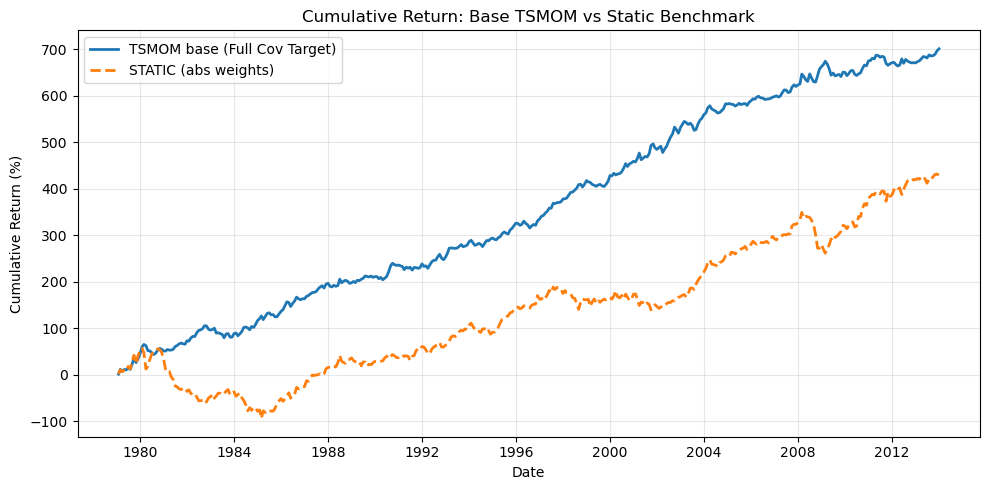

In [517]:
# Run strategy
strat_ret_base,strat_returns_by_class_base, static_ret, metrics_base = modular_tsmom(
    returns,
    asset_map,
    vol_type="static",   # uses full-sample vol in w0
    lookback=12,
    target_port_vol=0.18,
    target_asset_vol=0.40,
    start_date="1976-01-01",
    use_shrinkage=False,
)

# Print performance metrics
print(metrics_base)

# ===== Plot cumulative returns =====
plt.figure(figsize=(10, 5))
plt.plot(100 * strat_ret_base.cumsum(), label='TSMOM base (Full Cov Target)', lw=2)
plt.plot(100 * static_ret.cumsum(), label='STATIC (abs weights)', lw=2, linestyle='--')
plt.title('Cumulative Return: Base TSMOM vs Static Benchmark')
plt.ylabel('Cumulative Return (%)')
plt.xlabel('Date')
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()


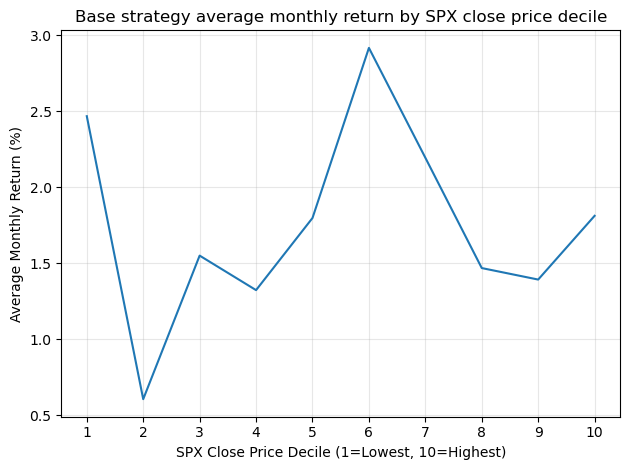

In [518]:
strat_returns_by_decile_base = pd.merge(pd.DataFrame(strat_ret_base,columns = ['TSMOM_base_return']),spx_data[['Close']],right_index=True,left_index=True, how = 'left')
strat_returns_by_decile_base['close_decile'] = pd.qcut(strat_returns_by_decile_base['Close'],q=10,labels=False) + 1 
strat_returns_by_decile_base.drop('Close',axis=1,inplace=True)
returns_by_deciles_base = strat_returns_by_decile_base.groupby('close_decile').mean()*100
plt.plot(returns_by_deciles_base.index, returns_by_deciles_base['TSMOM_base_return'])
plt.title('Base strategy average monthly return by SPX close price decile')
plt.xlabel('SPX Close Price Decile (1=Lowest, 10=Highest)')
plt.ylabel('Average Monthly Return (%)')
plt.grid(True, alpha=0.3)
plt.xticks(returns_by_deciles_base.index)
plt.tight_layout()
plt.show()

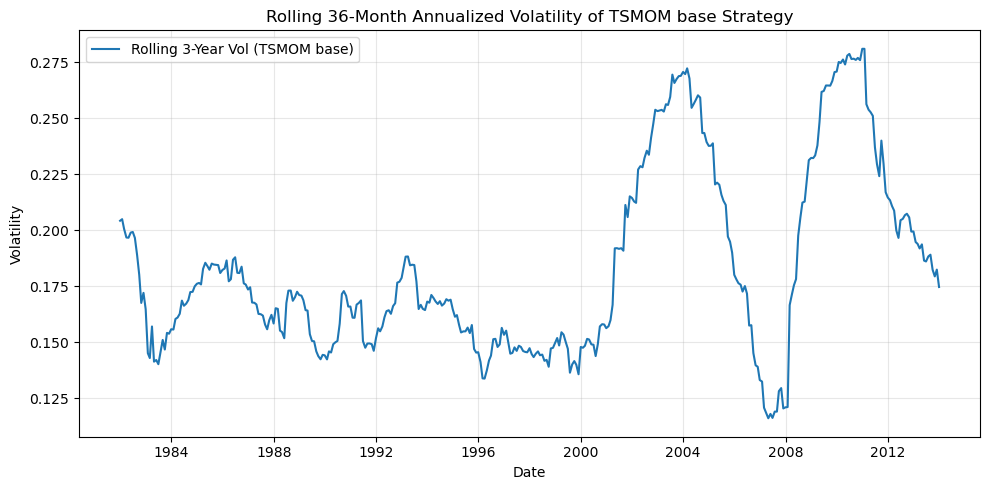

In [519]:
# 1) Compute rolling 3-year (36-month) annualized volatility
roll_vol_base = strat_ret_base.rolling(window=36).std() * np.sqrt(12)

# 2) Plot
plt.figure(figsize=(10,5))
plt.plot(roll_vol_base, label="Rolling 3-Year Vol (TSMOM base)", color='tab:blue')
plt.title("Rolling 36-Month Annualized Volatility of TSMOM base Strategy")
plt.ylabel("Volatility")
plt.xlabel("Date")
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()


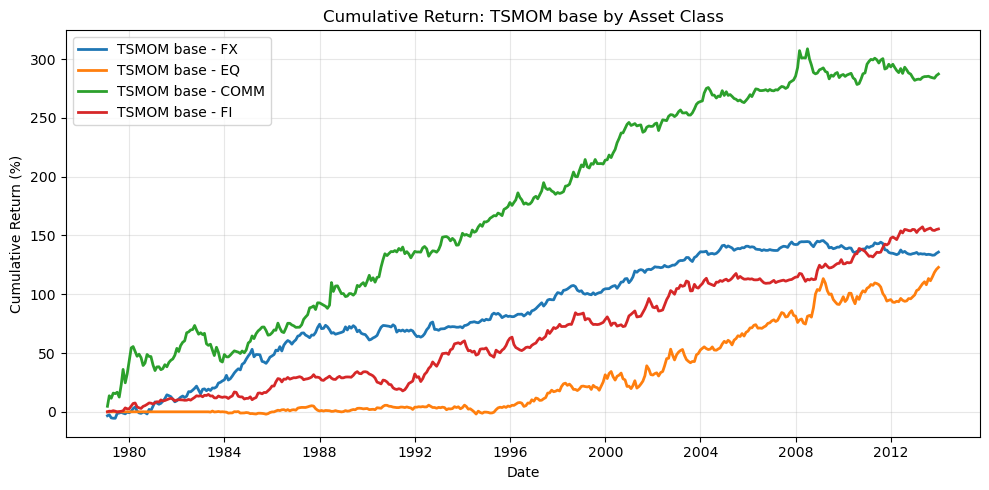

In [520]:
plt.figure(figsize=(10, 5))
for asset_class in strat_returns_by_class_base.columns:
    plt.plot(100 * strat_returns_by_class_base[asset_class].cumsum(), label=f'TSMOM base - {asset_class}', lw=2)
plt.title(f'Cumulative Return: TSMOM base by Asset Class')
plt.ylabel('Cumulative Return (%)')
plt.xlabel('Date')
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

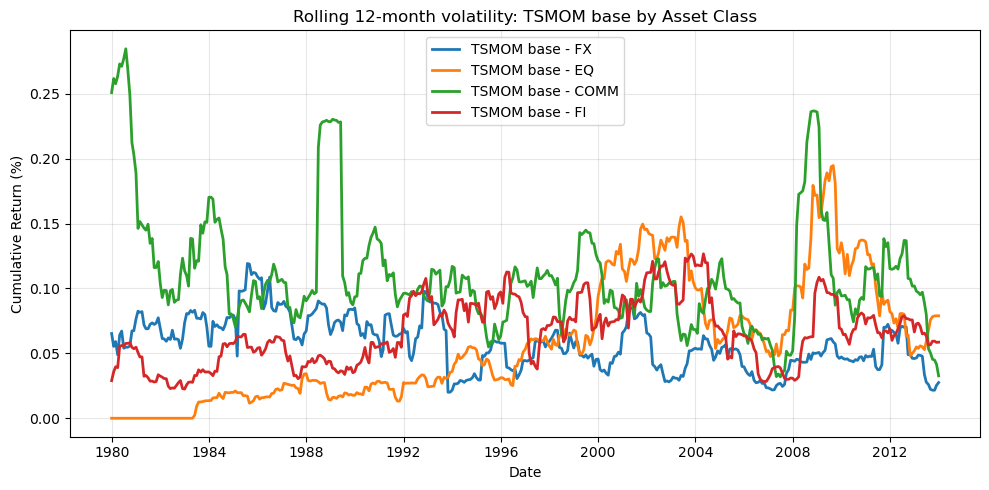

In [521]:
plt.figure(figsize=(10, 5))
for asset_class in strat_returns_by_class_base.columns:
    plt.plot(strat_returns_by_class_base[asset_class].rolling(window=12).std() * np.sqrt(12), label=f'TSMOM base - {asset_class}', lw=2)
plt.title(f'Rolling 12-month volatility: TSMOM base by Asset Class')
plt.ylabel('Cumulative Return (%)')
plt.xlabel('Date')
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

## Optimum stratetgy v1 (mid-term) - using rolling vol with no shrinkage or no cross-sectional signal

Using simple momentum signals
dict_keys([Timestamp('1979-01-31 00:00:00'), Timestamp('1979-02-28 00:00:00'), Timestamp('1979-03-30 00:00:00'), Timestamp('1979-04-30 00:00:00'), Timestamp('1979-05-31 00:00:00'), Timestamp('1979-06-29 00:00:00'), Timestamp('1979-07-31 00:00:00'), Timestamp('1979-08-31 00:00:00'), Timestamp('1979-09-28 00:00:00'), Timestamp('1979-10-31 00:00:00'), Timestamp('1979-11-30 00:00:00'), Timestamp('1979-12-31 00:00:00'), Timestamp('1980-01-31 00:00:00'), Timestamp('1980-02-29 00:00:00'), Timestamp('1980-03-31 00:00:00'), Timestamp('1980-04-30 00:00:00'), Timestamp('1980-05-30 00:00:00'), Timestamp('1980-06-30 00:00:00'), Timestamp('1980-07-31 00:00:00'), Timestamp('1980-08-29 00:00:00'), Timestamp('1980-09-30 00:00:00'), Timestamp('1980-10-31 00:00:00'), Timestamp('1980-11-28 00:00:00'), Timestamp('1980-12-31 00:00:00'), Timestamp('1981-01-30 00:00:00'), Timestamp('1981-02-27 00:00:00'), Timestamp('1981-03-31 00:00:00'), Timestamp('1981-04-30 00:00:00'), Timesta

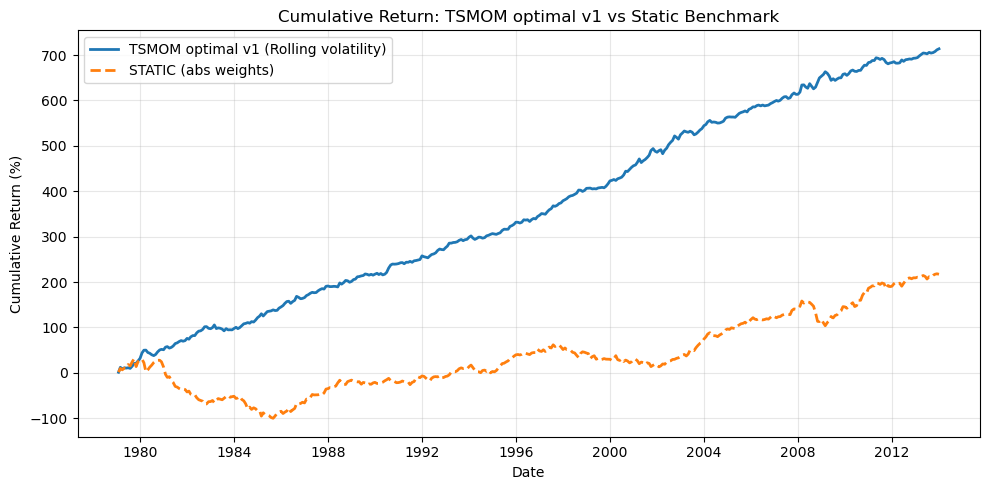

In [522]:
strat_ret_optimal_v1,strat_returns_by_class_optimal_v1,  static_ret_optimal_v1, metrics_optimal_v1 = modular_tsmom(
    returns,
    asset_map,
    vol_type="rolling",   # uses full-sample vol in w0
    lookback=11,
    rollingwindow=9,
    target_port_vol=0.14,
    target_asset_vol=0.40,
    start_date="1976-01-01",
    halflife=4,
    use_shrinkage=False,
)

# Print performance metrics
print(metrics_optimal_v1)

#===== Plot cumulative returns =====
plt.figure(figsize=(10, 5))
plt.plot(100 * strat_ret_optimal_v1.cumsum(), label='TSMOM optimal v1 (Rolling volatility)', lw=2)
plt.plot(100 * static_ret_optimal_v1.cumsum(), label='STATIC (abs weights)', lw=2, linestyle='--')
plt.title('Cumulative Return: TSMOM optimal v1 vs Static Benchmark')
plt.ylabel('Cumulative Return (%)')
plt.xlabel('Date')
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

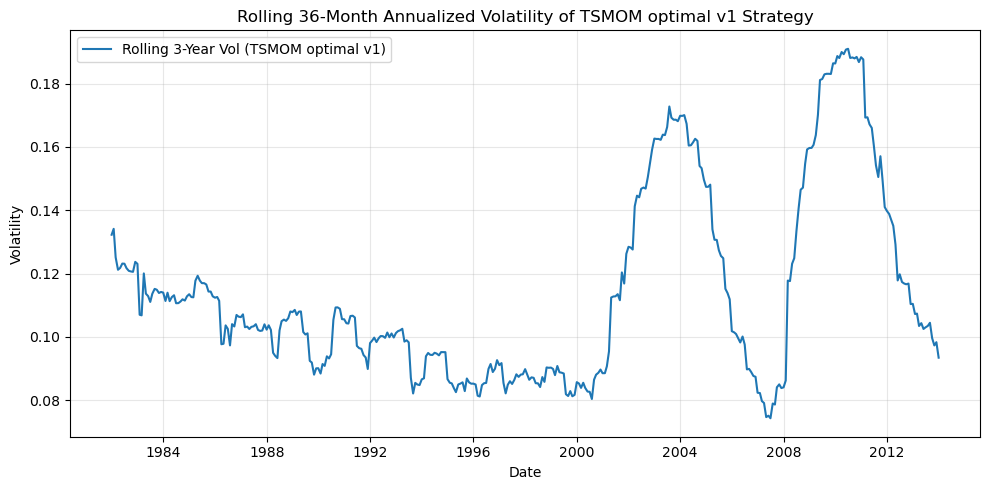

In [523]:
# 1) Compute rolling 3-year (36-month) annualized volatility
roll_vol_optimal_v1 = strat_ret_optimal_v1.rolling(window=36).std() * np.sqrt(12)

# 2) Plot
plt.figure(figsize=(10,5))
plt.plot(roll_vol_optimal_v1, label="Rolling 3-Year Vol (TSMOM optimal v1)", color='tab:blue')
plt.title("Rolling 36-Month Annualized Volatility of TSMOM optimal v1 Strategy")
plt.ylabel("Volatility")
plt.xlabel("Date")
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()


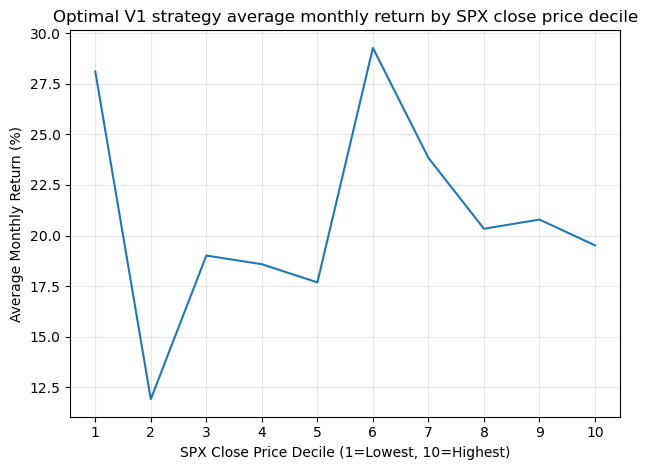

In [524]:
strat_returns_by_decile_optimal_v1= pd.merge(pd.DataFrame(strat_ret_optimal_v1,columns = ['TSMOM_base_return']),spx_data[['Close']],right_index=True,left_index=True, how = 'left')
strat_returns_by_decile_optimal_v1['close_decile'] = pd.qcut(strat_returns_by_decile_optimal_v1['Close'],q=10,labels=False) + 1 
strat_returns_by_decile_optimal_v1.drop('Close',axis=1,inplace=True)
returns_by_deciles_optimal_v1 = strat_returns_by_decile_optimal_v1.groupby('close_decile').mean()*100
returns_by_deciles_optimal_v1['annualized_TSMOM_base_return'] = 12*returns_by_deciles_optimal_v1['TSMOM_base_return']
plt.plot(returns_by_deciles_optimal_v1.index, returns_by_deciles_optimal_v1['annualized_TSMOM_base_return'])
plt.title('Optimal V1 strategy average monthly return by SPX close price decile')
plt.xlabel('SPX Close Price Decile (1=Lowest, 10=Highest)')
plt.ylabel('Average Monthly Return (%)')
plt.grid(True, alpha=0.3)
plt.xticks(returns_by_deciles_optimal_v1.index)
plt.tight_layout()
plt.show()

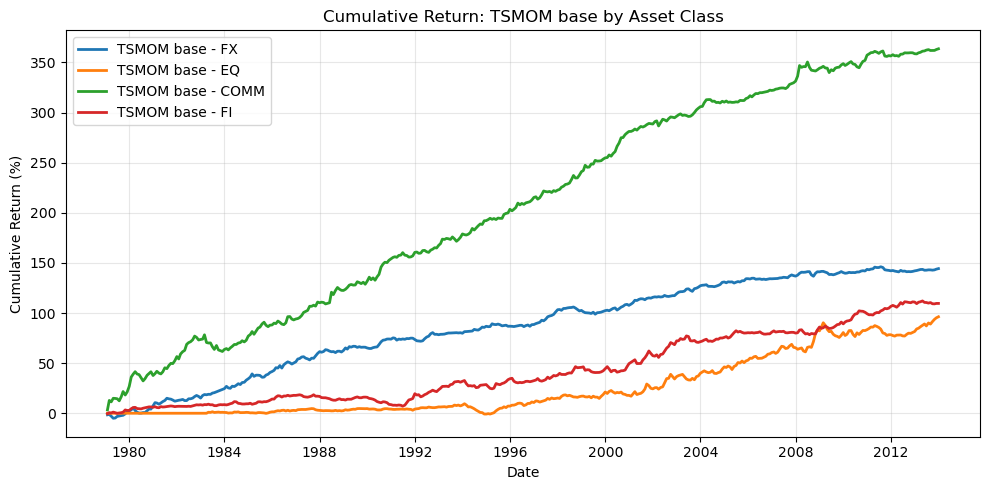

In [525]:
plt.figure(figsize=(10, 5))
for asset_class in strat_returns_by_class_optimal_v1.columns:
    plt.plot(100 * strat_returns_by_class_optimal_v1[asset_class].cumsum(), label=f'TSMOM base - {asset_class}', lw=2)
plt.title(f'Cumulative Return: TSMOM base by Asset Class')
plt.ylabel('Cumulative Return (%)')
plt.xlabel('Date')
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

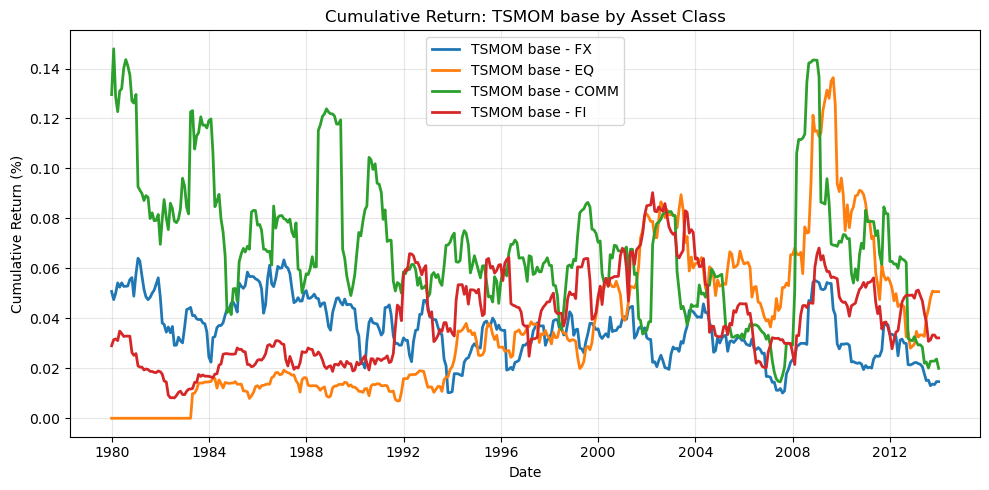

In [526]:
plt.figure(figsize=(10, 5))
for asset_class in strat_returns_by_class_optimal_v1.columns:
    plt.plot(strat_returns_by_class_optimal_v1[asset_class].rolling(window=12).std() * np.sqrt(12), label=f'TSMOM base - {asset_class}', lw=2)
plt.title(f'Cumulative Return: TSMOM base by Asset Class')
plt.ylabel('Cumulative Return (%)')
plt.xlabel('Date')
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

### Optimum stratetgy v2 (final) - using ewma with half-life of 4month, shrinkage applied, cross-sectional signal

Using cross-sectional rank-based momentum signals

Cross-sectional rank signal (within asset class):
  Lookback period: 11 months
  Long threshold: top 40% within each class
  Short threshold: bottom 40% within each class
  FX: 8 assets
  EQ: 14 assets
  COMM: 26 assets
  FI: 10 assets

Average positions per period by asset class:
  FX: Long=2.9, Short=1.8, Neutral=2.2
  EQ: Long=3.6, Short=1.7, Neutral=4.6
  COMM: Long=8.9, Short=8.1, Neutral=6.4
  FI: Long=3.6, Short=1.2, Neutral=3.5

Applying asset class risk control...
dict_keys([Timestamp('1979-01-31 00:00:00'), Timestamp('1979-02-28 00:00:00'), Timestamp('1979-03-30 00:00:00'), Timestamp('1979-04-30 00:00:00'), Timestamp('1979-05-31 00:00:00'), Timestamp('1979-06-29 00:00:00'), Timestamp('1979-07-31 00:00:00'), Timestamp('1979-08-31 00:00:00'), Timestamp('1979-09-28 00:00:00'), Timestamp('1979-10-31 00:00:00'), Timestamp('1979-11-30 00:00:00'), Timestamp('1979-12-31 00:00:00'), Timestamp('1980-01-31 00:00:00'), Timestamp('1980-02

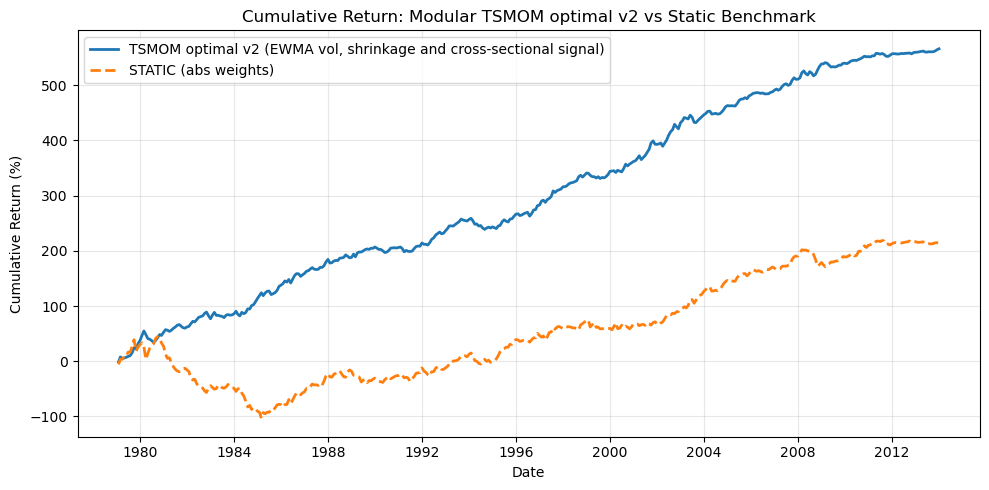

In [4]:
strat_ret_optimal_v2,strat_returns_by_class_optimal_v2, static_ret_optimal_v2, metrics_optimal_v2 = modular_tsmom(
    returns,
    asset_map,
    vol_type="rolling",   # uses full-sample vol in w0
    lookback=11,
    rollingwindow=9,
    target_port_vol=0.14,
    target_asset_vol=0.40,
    start_date="1976-01-01",
    halflife=4,
    use_shrinkage=True,
    use_cross_sectional_signal=True,
    include_ac_risk_control = True,
    cov_matrix_type = 'expanding',
)

# Print performance metrics
print(metrics_optimal_v2)

#===== Plot cumulative returns =====
plt.figure(figsize=(10, 5))
plt.plot(100 * strat_ret_optimal_v2.cumsum(), label='TSMOM optimal v2 (EWMA vol, shrinkage and cross-sectional signal)', lw=2)
plt.plot(100 * static_ret_optimal_v2.cumsum(), label='STATIC (abs weights)', lw=2, linestyle='--')
plt.title('Cumulative Return: Modular TSMOM optimal v2 vs Static Benchmark')
plt.ylabel('Cumulative Return (%)')
plt.xlabel('Date')
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

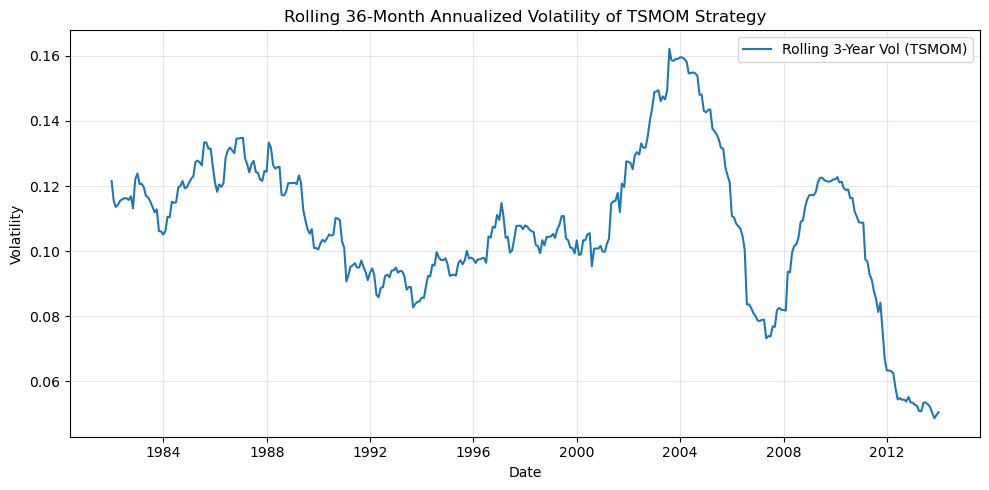

In [528]:
# 1) Compute rolling 3-year (36-month) annualized volatility
roll_vol_optimal_v2 = strat_ret_optimal_v2.rolling(window=36).std() * np.sqrt(12)

# 2) Plot
plt.figure(figsize=(10,5))
plt.plot(roll_vol_optimal_v2, label="Rolling 3-Year Vol (TSMOM)", color='tab:blue')
plt.title("Rolling 36-Month Annualized Volatility of TSMOM Strategy")
plt.ylabel("Volatility")
plt.xlabel("Date")
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()


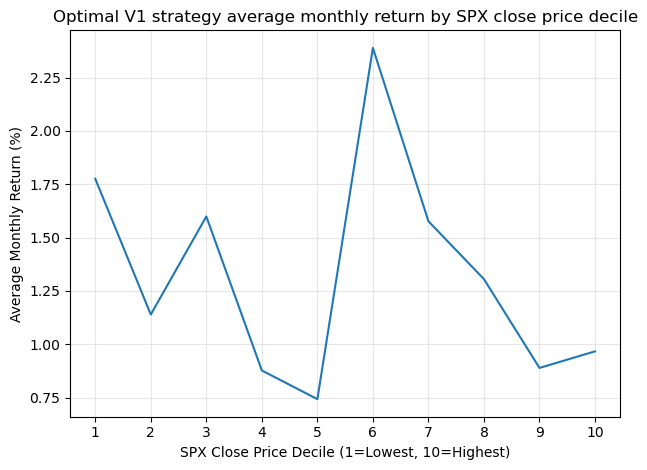

In [529]:
strat_returns_by_decile_optimal_v2= pd.merge(pd.DataFrame(strat_ret_optimal_v2,columns = ['TSMOM_base_return']),spx_data[['Close']],right_index=True,left_index=True, how = 'left')
strat_returns_by_decile_optimal_v2['close_decile'] = pd.qcut(strat_returns_by_decile_optimal_v2['Close'],q=10,labels=False) + 1 
strat_returns_by_decile_optimal_v2.drop('Close',axis=1,inplace=True)
returns_by_deciles_optimal_v2 = strat_returns_by_decile_optimal_v2.groupby('close_decile').mean()*100
plt.plot(returns_by_deciles_optimal_v2.index, returns_by_deciles_optimal_v2['TSMOM_base_return'])
plt.title('Optimal V1 strategy average monthly return by SPX close price decile')
plt.xlabel('SPX Close Price Decile (1=Lowest, 10=Highest)')
plt.ylabel('Average Monthly Return (%)')
plt.grid(True, alpha=0.3)
plt.xticks(returns_by_deciles_optimal_v2.index)
plt.tight_layout()
plt.show()

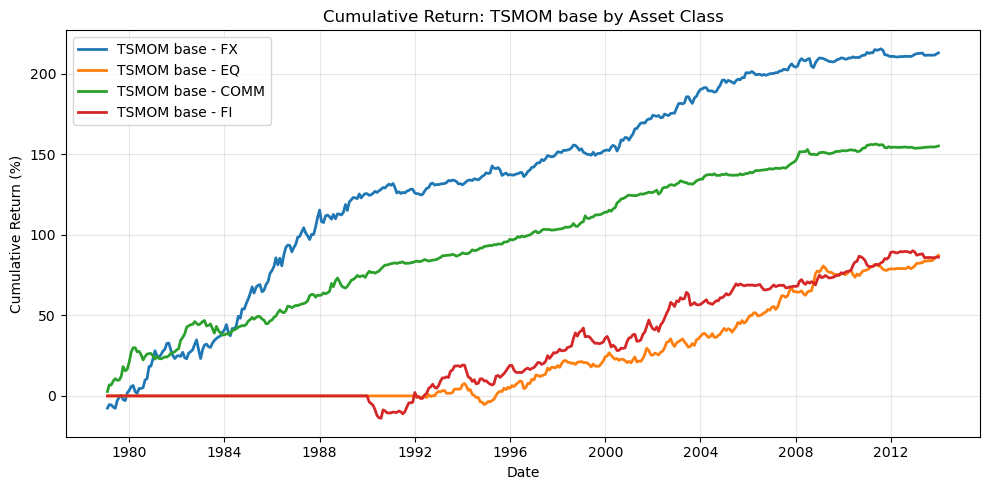

In [530]:
plt.figure(figsize=(10, 5))
for asset_class in strat_returns_by_class_optimal_v2.columns:
    plt.plot(100 * strat_returns_by_class_optimal_v2[asset_class].cumsum(), label=f'TSMOM base - {asset_class}', lw=2)
plt.title(f'Cumulative Return: TSMOM base by Asset Class')
plt.ylabel('Cumulative Return (%)')
plt.xlabel('Date')
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

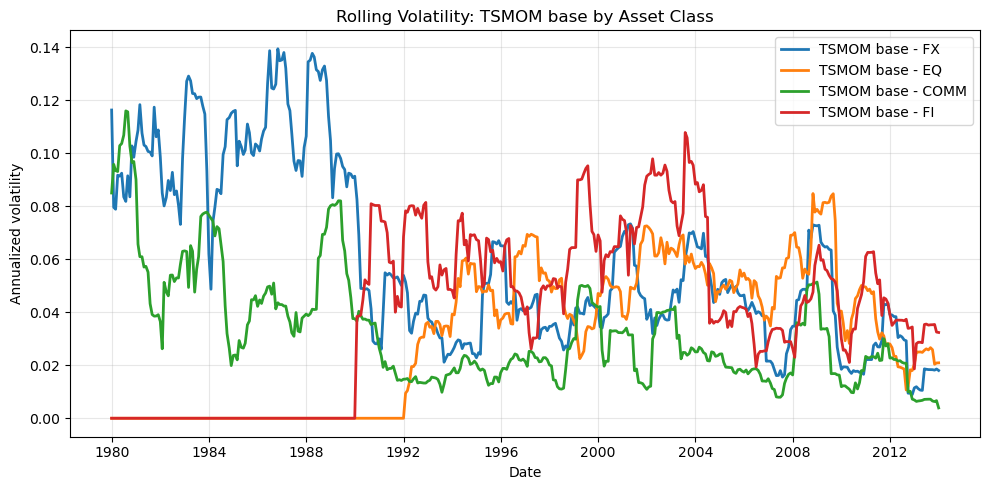

In [531]:
plt.figure(figsize=(10, 5))
for asset_class in strat_returns_by_class_optimal_v2.columns:
    plt.plot(strat_returns_by_class_optimal_v2[asset_class].rolling(window=12).std() * np.sqrt(12), label=f'TSMOM base - {asset_class}', lw=2)
plt.title(f'Rolling Volatility: TSMOM base by Asset Class')
plt.ylabel('Annualized volatility')
plt.xlabel('Date')
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

### Return comparison: Optimal v1 vs v2

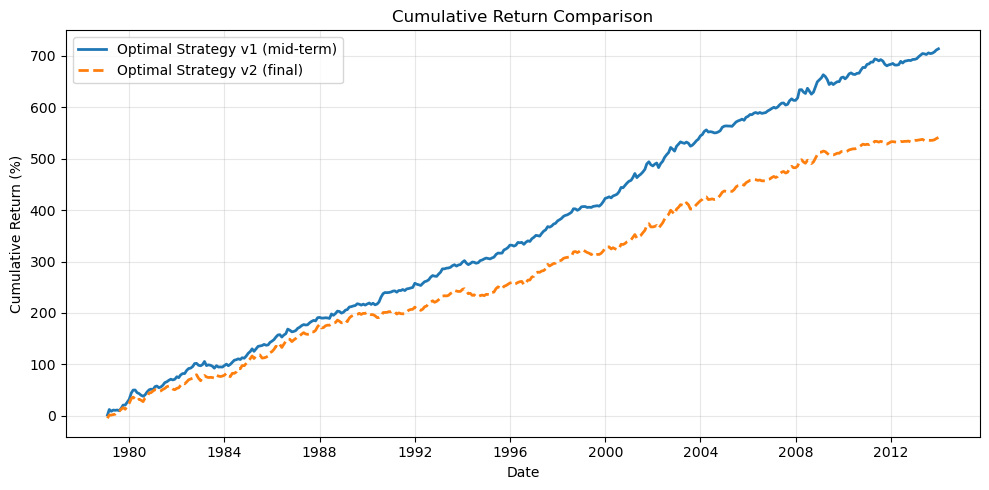

In [532]:
# Compute cumulative returns (in % for readability)
cum_optimal_v1 = 100 * strat_ret_optimal_v1.cumsum()
cum_optimal_v2 = 100 * strat_ret_optimal_v2.cumsum()

# Plot
plt.figure(figsize=(10, 5))
plt.plot(cum_optimal_v1, label='Optimal Strategy v1 (mid-term)', lw=2)
plt.plot(cum_optimal_v2, label='Optimal Strategy v2 (final)', lw=2, linestyle='--')

plt.title('Cumulative Return Comparison')
plt.ylabel('Cumulative Return (%)')
plt.xlabel('Date')
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()


### Volatility comparison: Optimal v1 vs v2

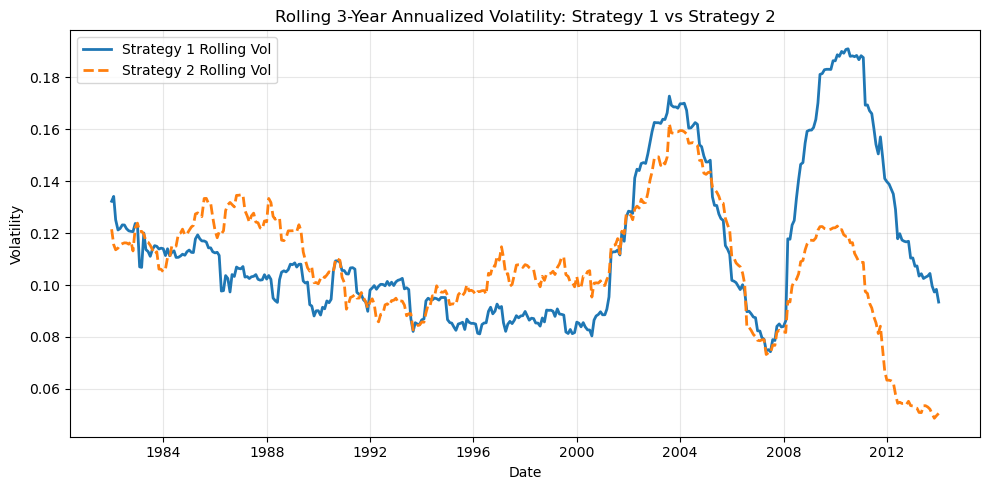

In [533]:

# Plot
plt.figure(figsize=(10, 5))
plt.plot(roll_vol_optimal_v1, label='Strategy 1 Rolling Vol', lw=2)
plt.plot(roll_vol_optimal_v2, label='Strategy 2 Rolling Vol', lw=2, linestyle='--')

plt.title('Rolling 3-Year Annualized Volatility: Strategy 1 vs Strategy 2')
plt.ylabel('Volatility')
plt.xlabel('Date')
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

### Summary Table

In [534]:
metrics_summary = pd.DataFrame(metrics_base).rename(columns={'TSMOM': 'Base TSMOM', 'STATIC': 'Static Benchmark'})
metrics_summary['TSMOM Optimal V1'] = pd.DataFrame(metrics_optimal_v1)['TSMOM']
metrics_summary['TSMOM Optimal V2'] = pd.DataFrame(metrics_optimal_v2)['TSMOM']
metrics_summary = metrics_summary.round(4)
rows_to_multiply = ['AnnRet_Gross', 'AnnRet_Net', 'AnnVol', 'TradingCost_Annual', 'RollingCost_Annual', 'TotalTransactionCost']
metrics_summary.loc[rows_to_multiply, :] = metrics_summary.loc[rows_to_multiply, :] * 100


In [535]:
metrics_summary

,Base TSMOM,Static Benchmark,TSMOM Optimal V1,TSMOM Optimal V2
AnnRet_Gross,20.040000,12.280000,20.390000,15.470000
AnnRet_Net,19.570000,12.080000,19.940000,15.020000
AnnVol,18.760000,25.010000,11.730000,10.900000
Sharpe_Gross,1.068200,0.491000,1.737900,1.419300
Sharpe_Net,1.043200,0.483200,1.699600,1.378500
AvgMonthlyTurnover,1.774000,0.633300,1.714200,1.750400
AnnTurnover,21.288000,7.599900,20.570400,21.004700
TradingCost_Annual,0.430000,0.150000,0.410000,0.420000
RollingCost_Annual,0.040000,0.040000,0.040000,0.020000
TotalTransactionCost,0.470000,0.200000,0.450000,0.440000


### Out of sample results

Using cross-sectional rank-based momentum signals

Cross-sectional rank signal (within asset class):
  Lookback period: 11 months
  Long threshold: top 40% within each class
  Short threshold: bottom 40% within each class
  FX: 8 assets
  EQ: 14 assets
  COMM: 26 assets
  FI: 10 assets

Average positions per period by asset class:
  FX: Long=2.8, Short=2.0, Neutral=2.3
  EQ: Long=4.2, Short=1.8, Neutral=5.0
  COMM: Long=9.1, Short=8.3, Neutral=6.6
  FI: Long=3.5, Short=1.5, Neutral=3.8

Applying asset class risk control...
dict_keys([Timestamp('1979-01-31 00:00:00'), Timestamp('1979-02-28 00:00:00'), Timestamp('1979-03-30 00:00:00'), Timestamp('1979-04-30 00:00:00'), Timestamp('1979-05-31 00:00:00'), Timestamp('1979-06-29 00:00:00'), Timestamp('1979-07-31 00:00:00'), Timestamp('1979-08-31 00:00:00'), Timestamp('1979-09-28 00:00:00'), Timestamp('1979-10-31 00:00:00'), Timestamp('1979-11-30 00:00:00'), Timestamp('1979-12-31 00:00:00'), Timestamp('1980-01-31 00:00:00'), Timestamp('1980-02

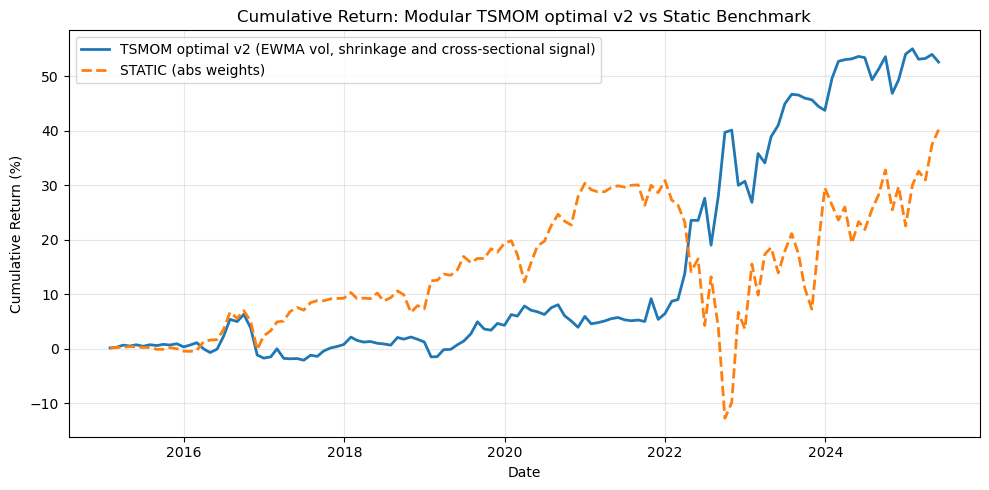

In [49]:
strat_ret_optimal_v2_oos,strat_returns_by_class_optimal_v2_oos, static_ret_optimal_v2_oos, metrics_optimal_v2_oos = modular_tsmom(
    returns_out_of_sample,
    asset_map,
    vol_type="rolling",   # uses full-sample vol in w0
    lookback=11,
    rollingwindow=9,
    target_port_vol=0.14,
    target_asset_vol=0.40,
    start_date="1976-01-01",
    halflife=4,
    use_shrinkage=True,
    use_cross_sectional_signal=True,
    include_ac_risk_control = True,
    cov_matrix_type = 'expanding',
    metrics_oos=True,
)

# Print performance metrics
print(metrics_optimal_v2_oos)

#===== Plot cumulative returns =====
plt.figure(figsize=(10, 5))
plt.plot(100 * strat_ret_optimal_v2_oos.cumsum(), label='TSMOM optimal v2 (EWMA vol, shrinkage and cross-sectional signal)', lw=2)
plt.plot(100 * static_ret_optimal_v2_oos.cumsum(), label='STATIC (abs weights)', lw=2, linestyle='--')
plt.title('Cumulative Return: Modular TSMOM optimal v2 vs Static Benchmark')
plt.ylabel('Cumulative Return (%)')
plt.xlabel('Date')
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

In [50]:
metrics_optimal_v2_oos

{'TSMOM': {'AnnRet_Gross': 0.05045603577428279,
  'AnnRet_Net': 0.04550501767904939,
  'AnnVol': 0.09586124745280306,
  'Sharpe_Gross': 0.5263444521637863,
  'Sharpe_Net': 0.47469669849073914,
  'AvgMonthlyTurnover': 1.9762029239196945,
  'AnnTurnover': 23.714435087036335,
  'TradingCost_Annual': 0.004742887017407267,
  'RollingCost_Annual': 0.00020813107782613382,
  'TotalTransactionCost': 0.004951018095233401,
  'AvgLeverage': 3.121966167392008,
  'AvgImbalance': 0.7434731775558012,
  'AvgNumPositions': 38.136,
  'AvgNumLong': 20.336,
  'AvgNumShort': 15.88},
 'STATIC': {'AnnRet_Gross': 0.03856210378576414,
  'AnnRet_Net': 0.03376938359938314,
  'AnnVol': 0.14625702517924608,
  'Sharpe_Gross': 0.2636598395085922,
  'Sharpe_Net': 0.23089067727172005,
  'AvgMonthlyTurnover': 1.9102454618978606,
  'AnnTurnover': 22.92294554277433,
  'TradingCost_Annual': 0.004584589108554866,
  'RollingCost_Annual': 0.00020813107782613382,
  'TotalTransactionCost': 0.0047927201863809995,
  'AvgLeverage'

In [51]:
metrics_summary = pd.DataFrame(metrics_optimal_v2_oos).rename(columns={'TSMOM': 'TSMOM Optimal V2', 'STATIC': 'Static Benchmark'})
metrics_summary = metrics_summary.round(4)
rows_to_multiply = ['AnnRet_Gross', 'AnnRet_Net', 'AnnVol', 'TradingCost_Annual', 'RollingCost_Annual', 'TotalTransactionCost']
metrics_summary.loc[rows_to_multiply, :] = metrics_summary.loc[rows_to_multiply, :] * 100

In [52]:
metrics_summary

,TSMOM Optimal V2,Static Benchmark
AnnRet_Gross,5.0500,3.8600
AnnRet_Net,4.5500,3.3800
AnnVol,9.5900,14.6300
Sharpe_Gross,0.5263,0.2637
Sharpe_Net,0.4747,0.2309
AvgMonthlyTurnover,1.9762,1.9102
AnnTurnover,23.7144,22.9229
TradingCost_Annual,0.4700,0.4600
RollingCost_Annual,0.0200,0.0200
TotalTransactionCost,0.5000,0.4800


## Fama French Decomposition

In [536]:
# ============
# 1) Load FF factors and fix Date (192607 -> 1926-07-01)
# ============
ff = pd.read_csv("ff_factors.csv")
ff["Date"] = pd.to_datetime(ff["Date"], format="%Y%m")  # monthly timestamp
ff = ff.set_index("Date").sort_index()

# Keep only Market (Mkt-RF); we'll treat RF=0 per your instruction
ff = ff[["Mkt-RF"]].copy()

# Convert FF units to decimals if they look like percents
# (Typical Fama-French CSVs are in percent units.)
if ff["Mkt-RF"].abs().median() > 1e-2:  # e.g., 2.5 -> 0.025
    ff["Mkt-RF"] = ff["Mkt-RF"] / 100.0

# Make a monthly Period index for robust alignment, then back to Timestamp (month start)
ff["Period"] = ff.index.to_period("M")
ff = ff.set_index("Period").drop(columns=[], errors="ignore")

# ============
# 2) Bring in your strategy series
#     Assumptions: strat_ret, static_ret, strat_ret_2 are pandas Series of monthly returns (decimals),
#     indexed by Timestamp (any day in month is fine).
# ============

def _to_period_series(s: pd.Series) -> pd.Series:
    s = s.copy()
    if not isinstance(s.index, pd.PeriodIndex):
        s.index = pd.to_datetime(s.index)  # ensure datetime-like
        s.index = s.index.to_period("M")   # normalize to monthly period
    return s.sort_index()

strats = {
    "strat_ret_base": _to_period_series(strat_ret_base),
    "static_ret": _to_period_series(static_ret),
    "strat_ret_optimal_v1": _to_period_series(strat_ret_optimal_v1),
    "strat_ret_optimal_v2": _to_period_series(strat_ret_optimal_v2),

}

# ============
# 3) Build aligned DataFrame (monthly), drop rows with any missing needed fields
# ============
# Merge strategies
df_strats = pd.concat(strats, axis=1)  # MultiIndex columns ('strat_ret', 'static_ret', ...)
df = df_strats.join(ff, how="inner")   # adds Mkt-RF
df = df.dropna()

# ============
# 4) Performance table (annualized, RF=0) and Corr vs Static
# ============

def ann_metrics(r: pd.Series):
    """Annualized mean, vol, and Sharpe (RF=0) for monthly return series r (decimal)."""
    ann_ret = r.mean() * 12.0
    ann_vol = r.std() * np.sqrt(12.0)
    sharpe = np.nan if ann_vol == 0 else ann_ret / ann_vol
    return ann_ret, ann_vol, sharpe

perf_rows = []
for name in ["strat_ret_base", "static_ret", "strat_ret_optimal_v1", "strat_ret_optimal_v2"]:
    ann_ret, ann_vol, sharpe = ann_metrics(df[name])
    corr_with_static = df[name].corr(df["static_ret"])
    perf_rows.append([name, ann_ret, ann_vol, sharpe, corr_with_static])

perf_table = pd.DataFrame(
    perf_rows,
    columns=["Strategy", "AnnRet", "AnnVol", "Sharpe", "Corr_with_Static"]
)

# Pretty print
pd.options.display.float_format = "{:,.6f}".format
print("=== Performance (annualized, RF=0) ===")
print(perf_table.to_string(index=False))
print()

# ============
# 5) CAPM regressions (market only) for each strategy (RF=0)
#     y_t = alpha + beta_mkt * (Mkt-RF)_t + eps_t
#     Also print Corr(strategy, Mkt-RF)
# ============

def capm_one(strategy_name: str):
    y = df[strategy_name]  # already monthly, decimal, RF=0
    X = sm.add_constant(df["Mkt-RF"])
    model = sm.OLS(y, X, missing="drop").fit()
    alpha = model.params["const"]
    beta_mkt = model.params["Mkt-RF"]
    corr_mkt = y.corr(df["Mkt-RF"])

    print(f"===== CAPM (Market only): {strategy_name} =====")
    print(f"Alpha (monthly): {alpha:,.6f}")
    print(f"Beta (Mkt-RF):   {beta_mkt:,.6f}")
    print(f"Corr with Mkt-RF: {corr_mkt:,.6f}")
    # If you also want annualized alpha, uncomment:
    # print(f"Alpha (annualized): {alpha*12:,.6f}")
    print()

for sname in ["strat_ret_base", "static_ret", "strat_ret_optimal_v1", "strat_ret_optimal_v2"]:
    capm_one(sname)


=== Performance (annualized, RF=0) ===
            Strategy   AnnRet   AnnVol   Sharpe  Corr_with_Static
      strat_ret_base 0.200420 0.187620 1.068222          0.148514
          static_ret 0.122786 0.250077 0.490994          1.000000
strat_ret_optimal_v1 0.203936 0.117343 1.737949          0.058517
strat_ret_optimal_v2 0.154666 0.108974 1.419283          0.085244

===== CAPM (Market only): strat_ret_base =====
Alpha (monthly): 0.017247
Beta (Mkt-RF):   -0.083297
Corr with Mkt-RF: -0.069729

===== CAPM (Market only): static_ret =====
Alpha (monthly): 0.004860
Beta (Mkt-RF):   0.820502
Corr with Mkt-RF: 0.515310

===== CAPM (Market only): strat_ret_optimal_v1 =====
Alpha (monthly): 0.017542
Beta (Mkt-RF):   -0.083575
Corr with Mkt-RF: -0.111862

===== CAPM (Market only): strat_ret_optimal_v2 =====
Alpha (monthly): 0.013263
Beta (Mkt-RF):   -0.057138
Corr with Mkt-RF: -0.082350



## Comparison with SG Trend

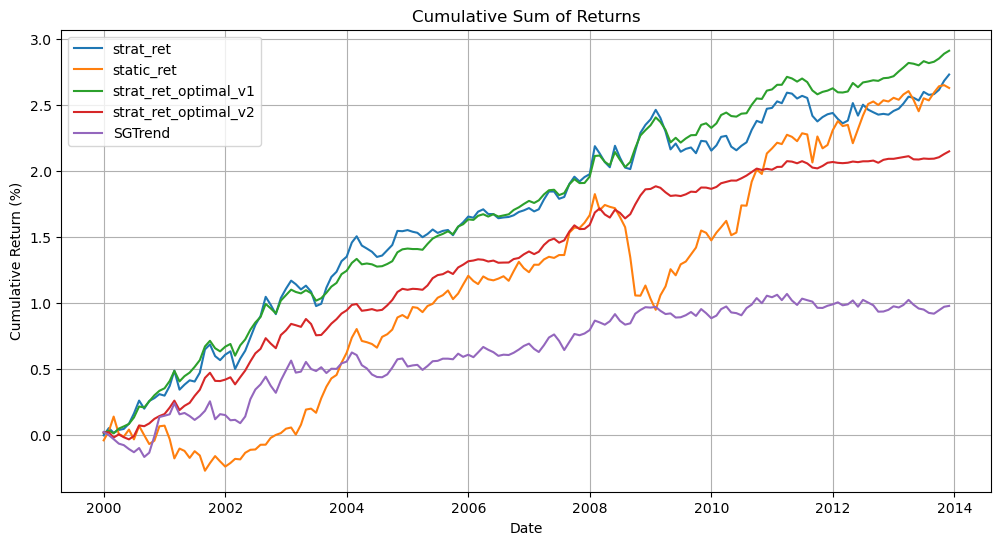

=== Performance (annualized, RF=0) ===
            Strategy   AnnRet   AnnVol   Sharpe  Corr_with_SGTrend
           strat_ret 0.194879 0.214669 0.907811           0.632790
          static_ret 0.187606 0.258151 0.726729           0.168913
strat_ret_optimal_v1 0.207763 0.136341 1.523843           0.636378
strat_ret_optimal_v2 0.153297 0.107765 1.422521           0.670662
             SGTrend 0.069650 0.148214 0.469927           1.000000


In [544]:

# =====================================================
# 1) Convert strategies to PeriodIndex (monthly)
# =====================================================
def to_period(s):
    s = s.copy()
    s.index = pd.to_datetime(s.index)
    s.index = s.index.to_period("M")
    return s.sort_index()

strat_ret_base_monthly     = to_period(strat_ret_base)
static_ret_monthly    = to_period(static_ret)
strat_ret_optimal_v1_monthly   = to_period(strat_ret_optimal_v1)
strat_ret_optimal_v2_monthly  = to_period(strat_ret_optimal_v2)

# =====================================================
# 2) Load and process SG Trend prices
# =====================================================
sg = pd.read_csv("sgtrend.csv")  # change filename if needed
sg['Date'] = pd.to_datetime(sg['Date'])
sg = sg.sort_values('Date')
sg.set_index('Date', inplace=True)

# Convert to monthly period
sg.index = sg.index.to_period("M")

# Simple returns (pct_change)
sg['SGTrend'] = sg['Last Price'].pct_change()
sg_ret = sg['SGTrend']

# =====================================================
# 3) Combine all 4 returns & keep only overlapping dates
# =====================================================
df = pd.concat([strat_ret_base_monthly, static_ret_monthly, strat_ret_optimal_v1_monthly,strat_ret_optimal_v2_monthly, sg_ret], axis=1, keys=[
    "strat_ret", "static_ret", "strat_ret_optimal_v1", "strat_ret_optimal_v2", "SGTrend"
])

df = df.dropna()



# =====================================================
# 4) Compute cumulative sum (not compounded)
# =====================================================
cum_df = df.cumsum()
cum_df_percent = cum_df * 100
# =====================================================
# 5) Plot all cumulative returns on the SAME plot
# =====================================================
plt.figure(figsize=(12,6))
for col in cum_df.columns:
    plt.plot(cum_df.index.to_timestamp(), cum_df[col], label=col)

plt.title("Cumulative Sum of Returns")
plt.xlabel("Date")
plt.ylabel("Cumulative Return (%)")
plt.legend()
plt.grid(True)
plt.show()

# =====================================================
# 6) Correlation and other metrics with SG Trend
# ====================================================

perf_rows = []
for name in [ "strat_ret", "static_ret", "strat_ret_optimal_v1", "strat_ret_optimal_v2", "SGTrend"]:
    ann_ret, ann_vol, sharpe = ann_metrics(df[name])     # annualized metrics
    corr_with_static = df[name].corr(df["SGTrend"])    # correlation vs static_ret
    perf_rows.append([name, ann_ret, ann_vol, sharpe, corr_with_static])

perf_table = pd.DataFrame(
    perf_rows,
    columns=["Strategy", "AnnRet", "AnnVol", "Sharpe", "Corr_with_SGTrend"]
)

print("=== Performance (annualized, RF=0) ===")
print(perf_table.to_string(index=False))